# Static cereal model

In [13]:
import numpy as np


Create a sequence of internodes.

In [12]:
nb_phytomers = 10
internodes = {i: 0 for i in range(nb_phytomers)}
internodes

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

Create a rectangular leaf surface.

AttributeError: 'int' object has no attribute 'ndim'

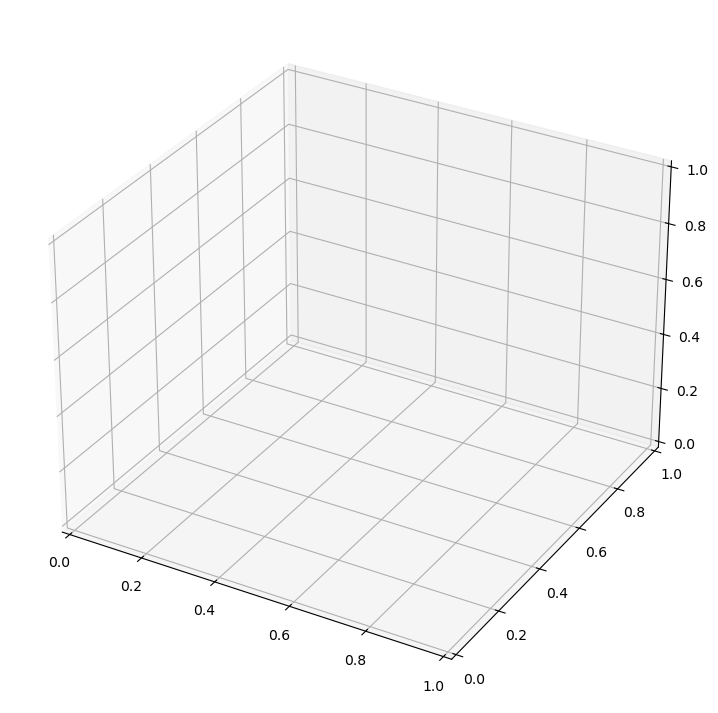

In [16]:
import matplotlib.pyplot as plt
 
 
# Creating dataset
x = np.outer(np.linspace(1, 10, 10), np.ones(10))
y = x.copy().T # transpose
z = 1
 
# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
 
# Creating plot
ax.plot_surface(x, y, z)
 
# show plot
plt.show()

Give the leaf another shape.

Make the leaf curvy.

In [15]:
from fitting import fit3

def leaf_shape_perez(nb_segment=100, insertion_angle=50, delta_angle=180, coef_curv=-0.2):
    def _curvature(s, coef_curv):
        return ((1 + coef_curv) * (s**2)) / (1 + coef_curv * (s**2))
        # positionRelativeLeaf=vector of relative position on the leaf [0;1]
        # decli_ini = declination (=inclination from the vertical) at leaf insertion (degree) [0;180]
        # decli_final = declination (=inclination from the vertical) at leaf tip (degree) [decli_ini; 180]
        # coefCurv= coefficient of leaf curvature [-1,inf] -1=no curvature inf=curvature at insertion
        # leafLength = length of the leaf

    s = np.linspace(0,1,nb_segment+1)
    ds = 1. / (nb_segment)
    angle_simu = _curvature(s, coef_curv=coef_curv) * np.radians(
        delta_angle) + np.radians(insertion_angle)
    dx = np.array([0] + (ds * np.sin(angle_simu)).tolist())[:-1]
    dy = np.array([0] + (ds * np.cos(angle_simu)).tolist())[:-1]
    x, y = np.cumsum(dx), np.cumsum(dy)
    length = np.sum(np.sqrt(dx**2 + dy**2))
    return x / length, y / length


def sr_prevot(nb_segment=10, alpha=-2.5):
    beta = -2 * (alpha + np.sqrt(-alpha))
    gamma = 2 * np.sqrt(-alpha) + alpha
    s = np.linspace(0, 1, nb_segment + 1)
    r = alpha * s**2 + beta * s + gamma
    return s, r


def parametric_leaf(nb_segment=10, insertion_angle=50, delta_angle=180,
                    coef_curv=-0.2, alpha=-2.5):
    """

    Args:
        nb_segment:
        insertion_angle:
        delta_angle:
        coef_curv:
        alpha:

    Returns:

    """
    nseg = min(100, nb_segment)
    x, y = leaf_shape_perez(nseg, insertion_angle, delta_angle, coef_curv)
    s, r = sr_prevot(nseg, alpha)
    return fit3(x, y, s, r, nb_points=nb_segment)

parametric_leaf()

(array([0.01158059, 0.0740559 , 0.16269755, 0.22850209, 0.34003134,
        0.43304339, 0.50298305, 0.5856507 , 0.655471  , 0.69765404,
        0.73790546, 0.73971991]),
 array([-0.00435771,  0.07485686,  0.14563391,  0.18391661,  0.2297415 ,
         0.25105956,  0.25561927,  0.24369694,  0.20914634,  0.16481779,
         0.04916036, -0.02920425]),
 array([0.        , 0.10088663, 0.21431826, 0.29044843, 0.41102494,
        0.50644874, 0.57653686, 0.66005981, 0.73796115, 0.79915289,
        0.92161439, 1.        ]),
 array([0.6666698 , 0.8265961 , 0.94944444, 0.99378572, 0.99674567,
        0.95421202, 0.89971329, 0.80031034, 0.66419465, 0.53155213,
        0.24029196, 0.        ]))

Create a sequence of leaves of the same length than the sequence of internode.

Arrange the leaf lengths according to a function.

Associate the leaves to the internodes 

In [ ]:
from math import pi, cos, sin, radians
import openalea.plantgl.all as pgl

def arrange_leaf(leaf, stem_diameter=0, inclination=1, relative=True):
    """Arrange a leaf to be placed along a stem with a given inclination.

    Args:
        leaf: a x, y, s, r tuple describing leaf shape
        stem_diameter: the diameter of the sem at the leaf insertion point
        inclination: if relative=False, the leaf basal inclination (deg). A
        multiplier to leaf basal inclination angle otherwise
        relative: (bool) controls the meaning of inclination parameter

    Returns:
        a modified x, y, s, r tuple

    """

    x, y, s, r = list(map(np.array, leaf))
    if relative and inclination == 1:
        x1, y1 = x, y
    else:
        basal_inclination = pgl.angle((x[1] - x[0], y[1] - y[0]), (0, 1))

        if relative:
            angle = inclination * basal_inclination
            angle = min(pi, angle)
        else:
            angle = radians(inclination)

        rotation_angle = basal_inclination - angle

        # rotation of the midrib
        cos_a = cos(rotation_angle)
        sin_a = sin(rotation_angle)

        x1 = x[0] + cos_a * x - sin_a * y
        y1 = y[0] + sin_a * x + cos_a * y
    leaf = x1 + stem_diameter / 2., y1, s, r

    return leaf